In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la

In [3]:
contact_filenames = ['contact/tij_InVS13.dat',
                    'contact/tij_InVS15.dat',
                    'contact/tij_LH10.dat',
                    'contact/tij_LyonSchool.dat',
                    'contact/tij_SFHH.dat',
                    'contact/tij_Thiers13.dat']

copresence_filenames = ['co-presence/tij_pres_InVS13.dat',
                       'co-presence/tij_pres_InVS15.dat',
                       'co-presence/tij_pres_LH10.dat',
                       'co-presence/tij_pres_LyonSchool.dat',
                       'co-presence/tij_pres_SFHH.dat',
                       'co-presence/tij_pres_Thiers13.dat']

metadata_filenames = ['metadata/metadata_InVS13.dat',
                     'metadata/metadata_InVS15.dat',
                     'metadata/metadata_LH10.dat',
                     'metadata/metadata_LyonSchool.dat',
                     'metadata/metadata_SFHH.dat',
                     'metadata/metadata_Thiers13.dat']

contact_output_filenames = ['output/temporally_aggregate_matrices/contact/agg_mat_InVS13.npy',
                           'output/temporally_aggregate_matrices/contact/agg_mat_InVS15.npy',
                           'output/temporally_aggregate_matrices/contact/agg_mat_LH10.npy',
                           'output/temporally_aggregate_matrices/contact/agg_mat_LyonSchool.npy',
                           'output/temporally_aggregate_matrices/contact/agg_mat_SFHH.npy',
                           'output/temporally_aggregate_matrices/contact/agg_mat_Thiers13.npy']

copresence_output_filenames = ['output/temporally_aggregate_matrices/co-presence/agg_mat_pres_InVS13.npy',
                               'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_InVS15.npy',
                               'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_LH10.npy',
                               'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_LyonSchool.npy',
                               'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_SFHH.npy',
                               'output/temporally_aggregate_matrices/co-presence/agg_mat_pres_Thiers13.npy']

In [4]:
def create_node_df_from_metadata_file(metadata_filename):
    with open(metadata_filename, 'r') as f:
        df = pd.DataFrame(l.rstrip().split() for l in f)
        df = pd.to_numeric(df[0])
        df = df.sort_values()
        df = df.reset_index(drop=True)
        return df

def create_tij_df_from_data_file(data_filename):
    with open(data_filename, 'r') as f:
        df = pd.DataFrame(l.rstrip().split() for l in f)
        df = df.apply(pd.to_numeric)
        return df    

def map_adj_mat_idx_to_node_id(nodes_df, adj_mat_idx):
    if adj_mat_idx in range(0, len(nodes_df)):
        return nodes_df[adj_mat_idx]
    else:
        print "Error, index {} does not map to a valid node".format(adj_mat_idx)
        return -1

def map_node_id_to_adj_mat_idx(nodes_df, node_id):
    if node_id in set(nodes_df):
        return nodes_df[nodes_df == node_id].index.item()
    else:
        print "Error, invalid node id {}".format(node_id)
        return -1
        
def create_temporally_aggregated_adj_mat(tij_df, nodes_df):
    n = len(nodes_df)
    A = np.zeros((n, n))
    
    i_col_idx = 1
    j_col_idx = 2
    
    num_rows = tij_df.shape[0]
    
    for row_idx in range(0, num_rows):
        # Pandas dataframe takes column index first, row index second
        i = map_node_id_to_adj_mat_idx(nodes_df, tij_df[i_col_idx][row_idx])
        j = map_node_id_to_adj_mat_idx(nodes_df, tij_df[j_col_idx][row_idx])
        
        # Increment edge weight
        A[i][j] += 1
        A[j][i] += 1
    
    return A

In [5]:
def compute_k_largest_eigenvalues(adj_mat, k):
    n = adj_mat.shape[0]
    if k < n:
        largest_k_eigvals = la.eigvalsh(adj_mat, eigvals=(n-k, n-1))
    else:
        largest_k_eigvals = la.eigvalsh(adj_mat)
        
    # Sort the eigenvalues from largest to smallest
    idx = largest_k_eigvals.argsort()[::-1]
    largest_k_eigvals = largest_k_eigvals[idx]
    return largest_k_eigvals


def plot_k_largest_eigvals_of_two_matrices(A, B, k):
    largest_k_eigvals_A = compute_k_largest_eigenvalues(A, k)
    largest_k_eigvals_B = compute_k_largest_eigenvalues(B, k)
    
    plt.figure()
    actual_k = len(largest_k_eigvals_A)
    eig_idx = range(0, actual_k)
    plt.subplot(1, 2, 1)
    plt.plot(eig_idx, largest_k_eigvals_A, 'ro')
    actual_k = len(largest_k_eigvals_A)
    eig_idx = range(0, actual_k)
    plt.subplot(1, 2, 1)
    plt.plot(eig_idx, largest_k_eigvals_B, 'bo')
    plt.show()
    

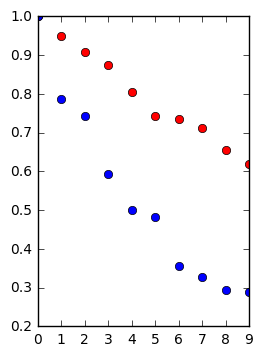

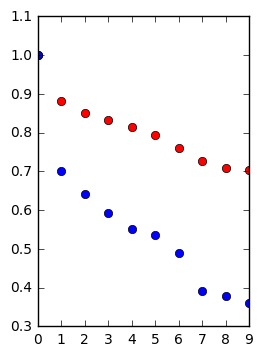

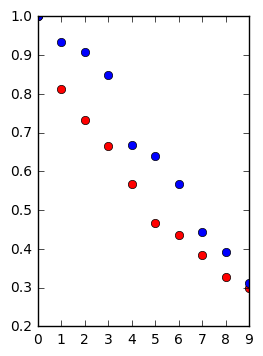

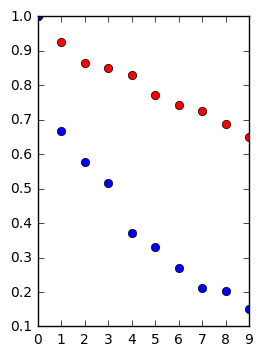

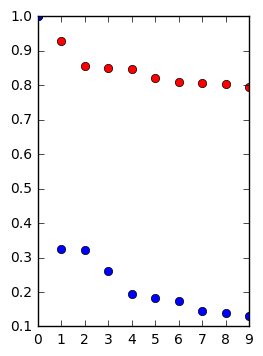

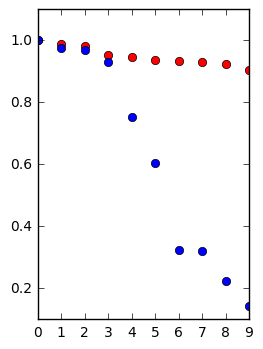

In [8]:
NUM_EIGVALS = 10

for f_idx in range(0, 6):
    A_contact = np.load(contact_output_filenames[f_idx])
    A_pres = np.load(copresence_output_filenames[f_idx])
    
    n = A_contact.shape[0]
    
    deg_vec_contact = np.sum(A_contact, axis=1)
    deg_vec_pres = np.sum(A_pres, axis=1)
    inv_sqrt_vec_contact = np.zeros(deg_vec_contact.shape)
    inv_sqrt_vec_pres = np.zeros(deg_vec_pres.shape)
    for i in range(0, n):
        if deg_vec_contact[i] != 0:
            inv_sqrt_vec_contact[i] = 1 / np.sqrt(deg_vec_contact[i])
        if deg_vec_pres[i] != 0:
            inv_sqrt_vec_pres[i] = 1 / np.sqrt(deg_vec_pres[i])
    
    D_contact = np.diag(inv_sqrt_vec_contact)
    D_pres = np.diag(inv_sqrt_vec_pres)
    
    #A_contact[A_contact > 0] = 1
    #A_pres[A_pres > 0] = 1
    
    A_contact_norm = np.matmul(np.matmul(D_contact, A_contact), D_contact)
    A_pres_norm = np.matmul(np.matmul(D_pres, A_pres), D_pres)
    
    plot_k_largest_eigvals_of_two_matrices(A_contact_norm, A_pres_norm, NUM_EIGVALS)

In [7]:
test = np.diag(np.eye(5))
test = np.divide(2, test)
test

array([ 2.,  2.,  2.,  2.,  2.])

# Old

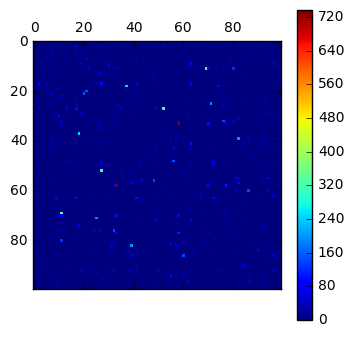

In [6]:
A = create_temporally_aggregated_adj_mat(tij_mat, nodes)
plt.matshow(A)
plt.colorbar()
plt.show()

In [5]:
nodes = create_node_df_from_metadata_file(metadata_filenames[0])
tij_mat = create_tij_df_from_data_file(contact_filenames[0])
map_node_id_to_adj_mat_idx(nodes, 987)
map_adj_mat_idx_to_node_id(nodes, 99)

987

In [18]:
# For each dataset, create the temporally aggregated adjacency matrices, and display them
for f_idx in range(0, 6):
    nodes = create_node_df_from_metadata_file(metadata_filenames[f_idx])
       
    tij = create_tij_df_from_data_file(contact_filenames[f_idx])
    A = create_temporally_aggregated_adj_mat(tij, nodes)
    np.save(contact_output_filenames[f_idx], A)
    print "Saved {}".format(contact_output_filenames[f_idx])
    
    tij = create_tij_df_from_data_file(copresence_filenames[f_idx])
    A = create_temporally_aggregated_adj_mat(tij, nodes)    
    np.save(copresence_output_filenames[f_idx], A)
    print "Saved {}".format(copresence_output_filenames[f_idx])


Saved output/temporally_aggregate_matrices/contact/agg_mat_InVS13.npy
Saved output/temporally_aggregate_matrices/co-presence/agg_mat_pres_InVS13.npy
Saved output/temporally_aggregate_matrices/contact/agg_mat_InVS15.npy
Saved output/temporally_aggregate_matrices/co-presence/agg_mat_pres_InVS15.npy
Saved output/temporally_aggregate_matrices/contact/agg_mat_LH10.npy
Saved output/temporally_aggregate_matrices/co-presence/agg_mat_pres_LH10.npy
Saved output/temporally_aggregate_matrices/contact/agg_mat_LyonSchool.npy
Saved output/temporally_aggregate_matrices/co-presence/agg_mat_pres_LyonSchool.npy
Saved output/temporally_aggregate_matrices/contact/agg_mat_SFHH.npy
Saved output/temporally_aggregate_matrices/co-presence/agg_mat_pres_SFHH.npy
Saved output/temporally_aggregate_matrices/contact/agg_mat_Thiers13.npy
Saved output/temporally_aggregate_matrices/co-presence/agg_mat_pres_Thiers13.npy


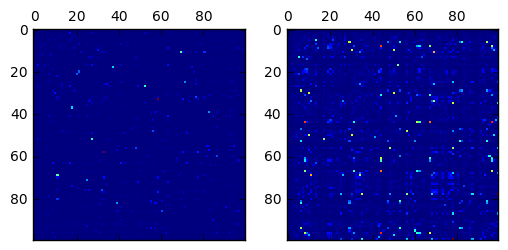

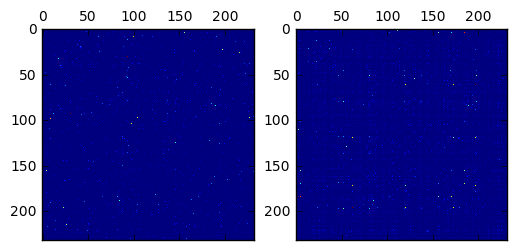

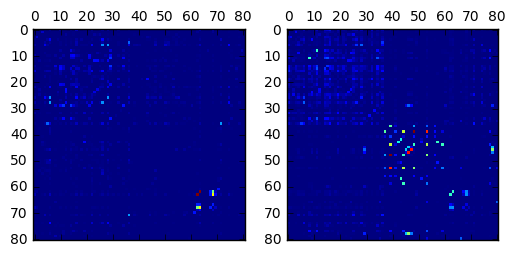

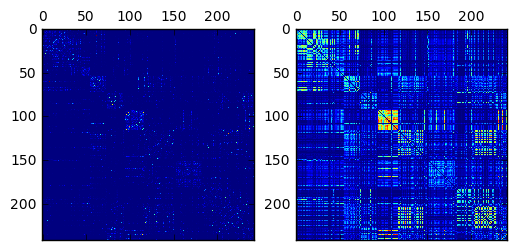

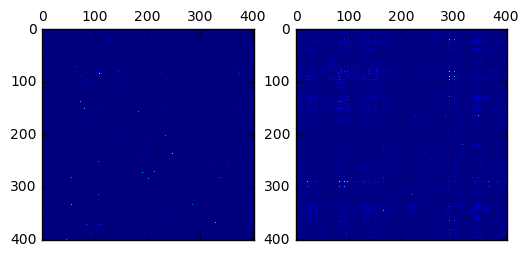

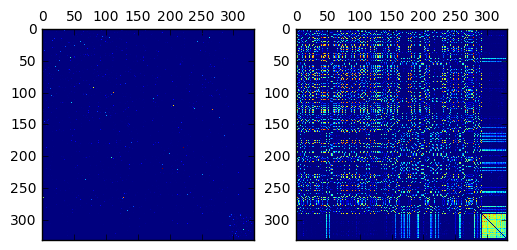

In [7]:
# For each dataset, create the temporally aggregated adjacency matrices, and display them
for f_idx in range(0, 6):
    nodes = create_node_df_from_metadata_file(metadata_filenames[f_idx])
   
    plt.figure(f_idx+1)
    
    tij = create_tij_df_from_data_file(contact_filenames[f_idx])
    A = create_temporally_aggregated_adj_mat(tij, nodes)
    output_file_contact = open(contact_output_filenames[f_idx], 'wb')
    output_file_contact.write(A)
    output_file_contact.close()
    plt.subplot(1, 2, 1)
    plt.matshow(A, fignum=False)
    
    tij = create_tij_df_from_data_file(copresence_filenames[f_idx])
    A = create_temporally_aggregated_adj_mat(tij, nodes)    
    output_file_pres = open(copresence_output_filenames[f_idx], 'wb')
    output_file_pres.write(A)
    output_file_pres.close()
    plt.subplot(1, 2, 2)
    plt.matshow(A, fignum=False)    
    
    plt.show()